**User Input and Image Generation**

Steps with Gradio:
1. Ask User for Image Concepts: Use Gradio to create a text input interface where users can enter their image concepts.
2. Clean User Input: Ensure the prompt is clean of unnecessary spaces or characters.
3. Prompt the Image Generation Agent: Call APIs to generate images using Stable Diffusion XL and DALL-E based on user input.

In [133]:
# Import Dependencies

# For environment variables
import os
from dotenv import load_dotenv

#For dataframes
import pandas as pd

# For API calls
import requests
import openai

# For image processing and viewing
import base64
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# For UI
import gradio as gr

# For caption generation
from transformers import BlipProcessor, BlipForConditionalGeneration

# Load dependencies to measure text output
import nltk
from rouge_score import rouge_scorer

# BLEU Score
from nltk.translate.bleu_score import sentence_bleu

import numpy as np
from sklearn.cluster import KMeans



In [134]:
# Load environment variables.
load_dotenv()

# Store the API key in a variable.
openai.api_key = os.getenv("OPENAI_API_KEY")
STABILITY_AI_API_KEY = os.getenv("STABILITY_AI_API_KEY")

# Set the model name for our LLMs.
OPENAI_MODEL = "gpt-3.5-turbo"

In [135]:
# Utility to view images for debugging
def view_base64_image(base64_string):
    """Decodes a base64 encoded image and displays it using matplotlib."""

    # Decode the base64 string
    image_data = base64.b64decode(base64_string)

    # Open the image using PIL
    image = Image.open(io.BytesIO(image_data))

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [136]:
# Utility to clean user input by removing extra spaces
def clean_user_input(user_query):
    cleaned_query = ' '.join(user_query.split())
    return cleaned_query

In [137]:
# Call Stability AI API and generate an image
def generate_stability_ai_image(prompt):
    host = 'https://api.stability.ai/v2beta/stable-image/generate/sd3'
    params = {
        "prompt" : prompt,
        "negative_prompt" : '',
        "aspect_ratio" : '1:1',
        "seed" : 0,
        "output_format" : 'jpeg',
        "model" : "sd3",
        "mode" : "text-to-image"
    }
    headers = {
        "Accept": "image/*",
        "Authorization": f"Bearer {STABILITY_AI_API_KEY}"
    }

    # Encode parameters
    files = {}
    image = params.pop("image", None)
    mask = params.pop("mask", None)
    if image is not None and image != '':
        files["image"] = open(image, 'rb')
    if mask is not None and mask != '':
        files["mask"] = open(mask, 'rb')
    if len(files)==0:
        files["none"] = ''

    # Send request
    print(f"Sending REST request to {host}...")
    response = requests.post(
        host,
        headers=headers,
        files=files,
        data=params
    )
    if not response.ok:
        raise Exception(f"HTTP {response.status_code}: {response.text}")

    return base64.b64encode(response.content)
    # To test the function: response = generate_stability_ai_image("cute shiba inu")


In [138]:
# Call Dall-E Open AI API and generate an image
def call_dalle_api(prompt):
    client = openai.OpenAI()
    response = client.images.generate(
    model="dall-e-2",
    prompt=prompt,
    size="512x512",
    quality="standard",
    n=1,
    response_format="b64_json"
    )

    return response.data[0].b64_json
    # To test the function: response = call_dalle_api("A realistic image of a shiba inu with a birthday hat on the street")

In [139]:
# Convert base64 string to a PIL Image object
def base64_to_pil_image(base64_string):

    # Decode the base64 string
    image_data = base64.b64decode(base64_string)

    # Create a BytesIO object from the decoded data
    image_bytes = BytesIO(image_data)

    # Open the image using PIL
    image = Image.open(image_bytes)

    return image

In [140]:
import hashlib

# This hash function is to create a unique id for the prompt
def generate_hash(input_string, algorithm='sha256'):
    """
    Generate a hash for a given string using the specified algorithm.
    
    Parameters:
        input_string (str): The input string to hash.
        algorithm (str): The hashing algorithm to use. Options include 'md5', 'sha1', 'sha256', etc.
        
    Returns:
        str: The hexadecimal representation of the hash.
    """
    # Get the hashing function from hashlib based on the specified algorithm
    hash_function = getattr(hashlib, algorithm)
    
    # Create a hash object and update it with the encoded string
    hash_object = hash_function()
    hash_object.update(input_string.encode('utf-8'))
    
    # Return the hexadecimal digest of the hash
    return hash_object.hexdigest()


In [141]:
# Generate images and assess their quality
def generate_images_with_quality(prompt):
    unique_id = generate_hash(prompt, algorithm='md5')

    cleaned_prompt = clean_user_input(prompt)
    stability_ai_image = base64_to_pil_image(generate_stability_ai_image(cleaned_prompt))
    dalle_image = base64_to_pil_image(call_dalle_api(cleaned_prompt))
        
    with open(f"generated_images/{unique_id}_prompt.txt", "w") as f:
        # Write text to the file
        f.write(f'{prompt}, {cleaned_prompt}')
        
    stability_ai_image.save(f'generated_images/{unique_id}_stability_ai.jpg')
    dalle_image.save(f'generated_images/{unique_id}_dalle.jpg')

    #sd_quality = assess_image_quality(sd_image)
    #dalle_quality = assess_image_quality(dalle_image)
    return stability_ai_image, dalle_image #, f"Quality: {sd_quality}", dalle_image, f"Quality: {dalle_quality}"

In [142]:
# Produce output
def create_image_record(prompt, user_preference):
    unique_id = generate_hash(prompt, algorithm='md5')        
    file_output = open('image_generation_results.csv', 'a')
    file_output.write(f'"{unique_id}","{prompt}","","","","","","","{user_preference}"\r\n')
    file_output.close()

In [143]:
def prefer_stability_ai(param):
    create_image_record(param, 'stability_ai')

def prefer_dalle(param):
    create_image_record(param, 'dall-e')

# Create the Gradio interface using Blocks
with gr.Blocks() as demo:
    gr.Markdown("# Text-to-Image Generation")
    gr.Markdown("Input a prompt to generate images using Stability AI and Dall-E.")

    # Input component for text concept
    concept_input = gr.Textbox(label="Enter Image Prompt", placeholder="Describe the image...")

    # Create a submit button
    generate_button = gr.Button("Generate Images")

    # Output components for displaying images
    stability_output = gr.Image(type="pil", label="Stability AI Image")
    dalle_output = gr.Image(type="pil", label="Dall-E Image")

    stability_ai_button = gr.Button("I like Stability AI image")
    stability_ai_button.click(
        fn=prefer_stability_ai, 
        inputs=[concept_input],
        outputs=[]
    )    

    dalle_button = gr.Button("I like Dall-E image")
    dalle_button.click(
        fn=prefer_dalle, 
        inputs=[concept_input],
        outputs=[]
    )    

    # Button click event to generate images
    generate_button.click(
        fn=generate_images_with_quality, 
        inputs=concept_input, 
        outputs=[stability_output, dalle_output]
    )
     
     # Add a clear button
    clear_button = gr.Button("Clear Input")
    clear_button.click(
        fn=lambda: "",  # Function to clear input
        inputs=[],
        outputs=[concept_input]
    )


# Launch the interface
demo.launch(share=True)

* Running on local URL:  http://127.0.0.1:7870
* Running on public URL: https://8099966b7e5f2b1248.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [144]:
import gradio as gr
from transformers import BlipProcessor, BlipForConditionalGeneration
from rouge_score import rouge_scorer

# Load the pre-trained model and processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# Function for caption generation
def generate_caption(image):
    inputs = processor(images=image, return_tensors="pt")
    out = model.generate(**inputs)
    caption = processor.decode(out[0], skip_special_tokens=True)
    return caption


def prefer_stability_ai(param):
    create_image_record(param, 'stability_ai')

def prefer_dalle(param):
    create_image_record(param, 'dall-e')

# Create the Gradio interface using Blocks
with gr.Blocks() as demo:
    gr.Markdown("# Text-to-Image Generation and Captioning")
    
    # Image Generation Section
    gr.Markdown("## Image Generation")
    concept_input = gr.Textbox(label="Enter Image Prompt", placeholder="Describe the image...")
    generate_button = gr.Button("Generate Images")
    stability_output = gr.Image(type="pil", label="Stability AI Image")
    dalle_output = gr.Image(type="pil", label="Dall-E Image")
    
    stability_ai_button = gr.Button("I like Stability AI image")
    stability_ai_button.click(
        fn=prefer_stability_ai, 
        inputs=[concept_input],
        outputs=[]
    )    

    dalle_button = gr.Button("I like Dall-E image")
    dalle_button.click(
        fn=prefer_dalle, 
        inputs=[concept_input],
        outputs=[]
    )    

    generate_button.click(
        fn=generate_images_with_quality, 
        inputs=concept_input, 
        outputs=[stability_output, dalle_output]
    )

    clear_button = gr.Button("Clear Input")
    clear_button.click(
        fn=lambda: "",  
        inputs=[],
        outputs=[concept_input]
    )
    
    # Caption Generation Section
    gr.Markdown("## Image Captioning")
    image_input = gr.Image(label="Upload an Image")
    caption_output = gr.Textbox(label="Generated Caption")
    generate_caption_button = gr.Button("Generate Caption")
    
    generate_caption_button.click(
        fn=generate_caption, 
        inputs=image_input, 
        outputs=caption_output
    )

# Launch the interface
demo.launch(share=True)


* Running on local URL:  http://127.0.0.1:7871
* Running on public URL: https://71e2a742ce6a303f84.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [1]:
import gradio as gr
from transformers import pipeline
from PIL import Image
import torch

2024-10-31 00:51:38.225853: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Load the image captioning pipeline
img_captioning_pipeline = pipeline("image-captioning", model="Salesforce/blip-image-captioning-base")


In [ ]:
# Preprocessing function
def preprocess_image(image, target_size=(225, 225)):
    image = image.resize(target_size, Image.ANTIALIAS) # .ANTIALIAS to maintain image quality
    transform = transforms.Compose([
        transforms.ToTensor(),  # To tensor to change PIL to Pytorch tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(image).unsqueeze(0)  # Add batch dimension


In [ ]:
# Define the function to generate captions
def generate_caption(image):
    try:
        # Preprocess the image
        image_tensor = preprocess_image(image)

        # Generate captions
        captions = captioning_pipeline(image_tensor)  # Use the pipeline directly on the tensor
        return captions[0]['caption']  # Return the first caption
    except Exception as e:
        return f"Error: {str(e)}"


**Image Evaluation, Relevance Check, and Description Generation**

Steps:
1. Evaluate Image Relevance: Use an LLM to assess whether the generated image is relevant to the prompt.
2. Generate Image Descriptions: Use a classifier to create descriptive summaries of the images.
3. Compare Models: Analyze how each model's output aligns with the user query.

In [146]:
# Function for caption generation
def generate_caption(image):
    # Process the image and generate a caption
    inputs = processor(images=image, return_tensors="pt")
    out = model.generate(**inputs)
    caption = processor.decode(out[0], skip_special_tokens=True)
    return caption

In [147]:
# Function to calculate Rouge score
def calculate_rouge(reference, generated):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, generated)
    return scores

In [148]:
# This function calculates scores for the models and saves back to the results file
def process_image_record(record_id):
    # Load prompt for images
    prompt_file = open(f'generated_images/{record_id}_prompt.txt')
    prompt = prompt_file.read().split(',')[1]

    # Generate caption for Stability AI image
    img = Image.open(f"generated_images/{record_id}_stability_ai.jpg")
    stability_ai_caption = generate_caption(img)

    # Generate caption for Dall-E image
    img = Image.open(f"generated_images/{record_id}_dalle.jpg")
    dalle_caption = generate_caption(img)

    # Generate Stability AI BLEU score
    # Prompted captions and generated captions
    reference_captions = [prompt]
    generated_captions = [stability_ai_caption]

    # Calculate BLEU scores for each pair of reference and generated captions
    bleu_scores = [sentence_bleu([ref.split()], gen.split()) for ref, gen in zip(reference_captions, generated_captions)]

    # Calculate the average BLEU score
    stability_ai_bleu = sum(bleu_scores) / len(bleu_scores)

    # Print the average BLEU score
    print(f"Average BLEU Score: {stability_ai_bleu:.4f}")

    # Generate Dall-E BLEU score
    # Prompted captions and generated captions
    reference_captions = [prompt]
    generated_captions = [dalle_caption]

    # Calculate BLEU scores for each pair of reference and generated captions
    bleu_scores = [sentence_bleu([ref.split()], gen.split()) for ref, gen in zip(reference_captions, generated_captions)]

    # Calculate the average BLEU score
    dalle_bleu = sum(bleu_scores) / len(bleu_scores)

    # Print the average BLEU score
    print(f"Average BLEU Score: {dalle_bleu:.4f}")

    # Generate Stability AI ROUGE Score
    reference_captions = [prompt]
    generated_captions = [stability_ai_caption]
    for ref, gen in zip(reference_captions, generated_captions):
        stability_ai_rouge_score = calculate_rouge(ref, gen)
        print(f"ROUGE scores for reference: '{ref}' and generated: '{gen}': {stability_ai_rouge_score}")

    # Generate Dall-E ROUGE Score
    reference_captions = [prompt]
    generated_captions = [dalle_caption]
    for ref, gen in zip(reference_captions, generated_captions):
        dalle_rouge_score = calculate_rouge(ref, gen)
        print(f"ROUGE scores for reference: '{ref}' and generated: '{gen}': {dalle_rouge_score}")

    # Load dataframe
    df = pd.read_csv('image_generation_results.csv')

    # Get record for prompt
    record = df[df["Unique Id"] == record_id]

    # Update fields
    record["Stability AI Caption"] = stability_ai_caption
    record["Dall-E Caption"] = dalle_caption
    record["Stability AI BLEU"] = stability_ai_bleu
    record["Dall-E BLEU"] = dalle_bleu
    record["Stability AI Rouge"] = str(stability_ai_rouge_score)
    record["Dall-E Rouge"] = str(dalle_rouge_score)
    df[df["Unique Id"] == record_id] = record

    # Save back to file
    df.to_csv('image_generation_results.csv', index=False)        


In [150]:
# Loop through records in results to fill in scores
results_df = pd.read_csv('image_generation_results.csv')
for record in results_df["Unique Id"].unique():
    caption = str(results_df[results_df["Unique Id"] == record]["Stability AI Caption"])
    # Only process unprocessed records
    if "NaN" in caption:
        print('processing record')
        process_image_record(record)
    else:
        print('record is already processed')

record is already processed
record is already processed
record is already processed
record is already processed
record is already processed
record is already processed
record is already processed
record is already processed
record is already processed
record is already processed
record is already processed
record is already processed
record is already processed
record is already processed
record is already processed
record is already processed
record is already processed
record is already processed
record is already processed
record is already processed
record is already processed
record is already processed
record is already processed
record is already processed
record is already processed
record is already processed
record is already processed
processing record


/Applications/anaconda3/envs/dev/lib/python3.10/site-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/Applications/anaconda3/envs/dev/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Applications/anaconda3/envs/dev/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  wa

Average BLEU Score: 0.0000
Average BLEU Score: 0.0000
ROUGE scores for reference: ' the hulk' and generated: 'hulk hulk hulk hulk hulk hulk hulk hulk hulk hulk hulk hulk hulk hulk hulk hulk hulk hulk hulk': {'rouge1': Score(precision=0.05263157894736842, recall=0.5, fmeasure=0.09523809523809525), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.05263157894736842, recall=0.5, fmeasure=0.09523809523809525)}
ROUGE scores for reference: ' the hulk' and generated: 'two men dressed as superheros, one with a cape and the other with a cape': {'rouge1': Score(precision=0.06666666666666667, recall=0.5, fmeasure=0.11764705882352941), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.06666666666666667, recall=0.5, fmeasure=0.11764705882352941)}
processing record


/Applications/anaconda3/envs/dev/lib/python3.10/site-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Average BLEU Score: 0.0000
Average BLEU Score: 0.0000
ROUGE scores for reference: ' static shock' and generated: 'a painting of a man with a purple and yellow jacket': {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}
ROUGE scores for reference: ' static shock' and generated: 'a man with glasses and a red shirt': {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}
processing record


/var/folders/bp/ghj2hg8n63ngp97nh99m0cr80000gn/T/ipykernel_4352/1521277803.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  record["Stability AI Caption"] = stability_ai_caption
/var/folders/bp/ghj2hg8n63ngp97nh99m0cr80000gn/T/ipykernel_4352/1521277803.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  record["Dall-E Caption"] = dalle_caption
/var/folders/bp/ghj2hg8n63ngp97nh99m0cr80000gn/T/ipykernel_4352/1521277803.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

Average BLEU Score: 0.0000
Average BLEU Score: 0.0000
ROUGE scores for reference: ' the police chasing criminal' and generated: 'a group of police officers running down a street': {'rouge1': Score(precision=0.1111111111111111, recall=0.25, fmeasure=0.15384615384615383), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1111111111111111, recall=0.25, fmeasure=0.15384615384615383)}
ROUGE scores for reference: ' the police chasing criminal' and generated: 'a group of people walking on a red surface': {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}


/Applications/anaconda3/envs/dev/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Applications/anaconda3/envs/dev/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Applications/anaconda3/envs/dev/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider usi

In [151]:
# Empty defaults for analysis
prompt = ''
stability_ai_caption = ''
dalle_caption = ''

In [152]:
results_df.head()

,Unique Id,Prompt,Stability AI Caption,Dall-E Caption,Stability AI BLEU,Dall-E BLEU,Stability AI Rouge,Dall-E Rouge,User Preference
0,71ed1d6a8810cdd416a7dc4385df318c,nigeria in summer,a woman walking down a dirt road,a view of the village from the top of the hill,0.000000e+00,0.0,"{'rouge1': Score(precision=0.0, recall=0.0, fm...","{'rouge1': Score(precision=0.0, recall=0.0, fm...",dall-e
1,71ed1d6a8810cdd416a7dc4385df318c,nigeria in summer,a woman walking down a dirt road,a view of the village from the top of the hill,0.000000e+00,0.0,"{'rouge1': Score(precision=0.0, recall=0.0, fm...","{'rouge1': Score(precision=0.0, recall=0.0, fm...",dall-e
2,38b643a164b201883450c4b031fe5b74,nigeria in july,a woman walking through a field of banana trees,a view of the sea from the top of a hill,0.000000e+00,0.0,"{'rouge1': Score(precision=0.0, recall=0.0, fm...","{'rouge1': Score(precision=0.0, recall=0.0, fm...",stability_ai
3,d193b7a476a8b6c901729d254785f5fe,chicago at night,chicago skyline at night,the view from the top of the empire building,1.054769e-154,0.0,"{'rouge1': Score(precision=0.75, recall=1.0, f...","{'rouge1': Score(precision=0.0, recall=0.0, fm...",dall-e
4,995456173fa7b99e9362f0febe62dfe7,china in the winter time,a snowy scene in the mountains of china,a park with trees and snow,7.176382e-155,0.0,"{'rouge1': Score(precision=0.375, recall=0.6, ...","{'rouge1': Score(precision=0.0, recall=0.0, fm...",stability_ai


In [153]:
results_df.columns = results_df.columns.str.strip()


In [154]:
print(results_df.columns)

Index(['Unique Id', 'Prompt', 'Stability AI Caption', 'Dall-E Caption',
       'Stability AI BLEU', 'Dall-E BLEU', 'Stability AI Rouge',
       'Dall-E Rouge', 'User Preference'],
      dtype='object')


In [155]:

# Create lists for reference (input) and generated captions (output)
reference_captions = [prompt, prompt]
generated_captions = [stability_ai_caption, dalle_caption]

# Calculate BLEU scores
bleu_scores = [sentence_bleu([ref.split()], gen.split()) for ref, gen in zip(reference_captions, generated_captions)]

# Calculate ROUGE scores
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores = [scorer.score(ref, gen) for ref, gen in zip(reference_captions, generated_captions)]
rouge1_scores = [score['rouge1'].fmeasure for score in rouge_scores]


In [156]:
# Check BLEU and ROUGE scores
print("BLEU Scores:", bleu_scores)
print("ROUGE-1 Scores:", rouge1_scores)

# Prepare data for K-means
X = np.array(list(zip(bleu_scores, rouge1_scores)))

# Check the raw data before scaling
print("Raw Data (before scaling):\n", X)

# Apply StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Check the scaled data
print("Scaled Data:\n", X_scaled)

BLEU Scores: [0, 0]
ROUGE-1 Scores: [0.0, 0.0]
Raw Data (before scaling):
 [[0. 0.]
 [0. 0.]]
Scaled Data:
 [[0. 0.]
 [0. 0.]]


/Applications/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Applications/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Applications/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Figure size 1200x800 with 0 Axes>

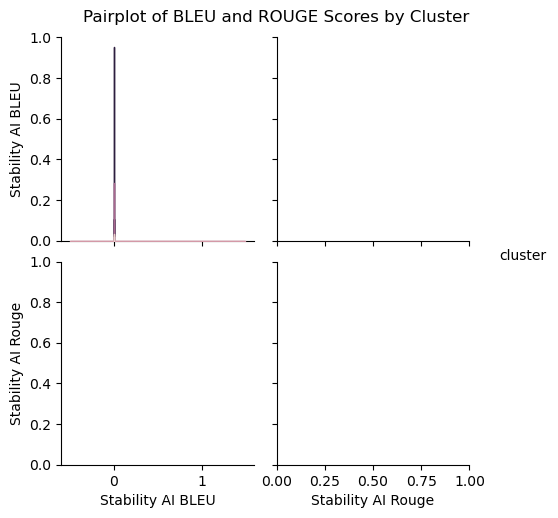

In [161]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# Load your DataFrame
df = pd.read_csv('image_generation_results.csv')

# Vectorize the captions
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['Stability AI Caption'])

# Convert sparse matrix to a DataFrame and keep track of the original indices
X_df = pd.DataFrame(X.toarray())
X_df['original_index'] = df.index  # Keep track of the original index

# Perform K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(X_df.drop('original_index', axis=1))

# Initialize the 'cluster' column in df with NaN
df['cluster'] = np.nan

# Assign cluster labels to the correct indices
for i in range(len(cluster_labels)):
    df.loc[X_df['original_index'].iloc[i], 'cluster'] = cluster_labels[i]

# Ensure BLEU and ROUGE scores are numeric
df['Stability AI BLEU'] = pd.to_numeric(df['Stability AI BLEU'], errors='coerce')
df['Stability AI Rouge'] = pd.to_numeric(df['Stability AI Rouge'], errors='coerce')

# Plot the results
plt.figure(figsize=(12, 8))
sns.pairplot(df, hue='cluster', vars=['Stability AI BLEU', 'Stability AI Rouge'], dropna=True)
plt.suptitle('Pairplot of BLEU and ROUGE Scores by Cluster', y=1.02)
plt.show()


Reference Captions: ['', '']
Generated Captions: ['', '']


/Applications/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/base.py:1474: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


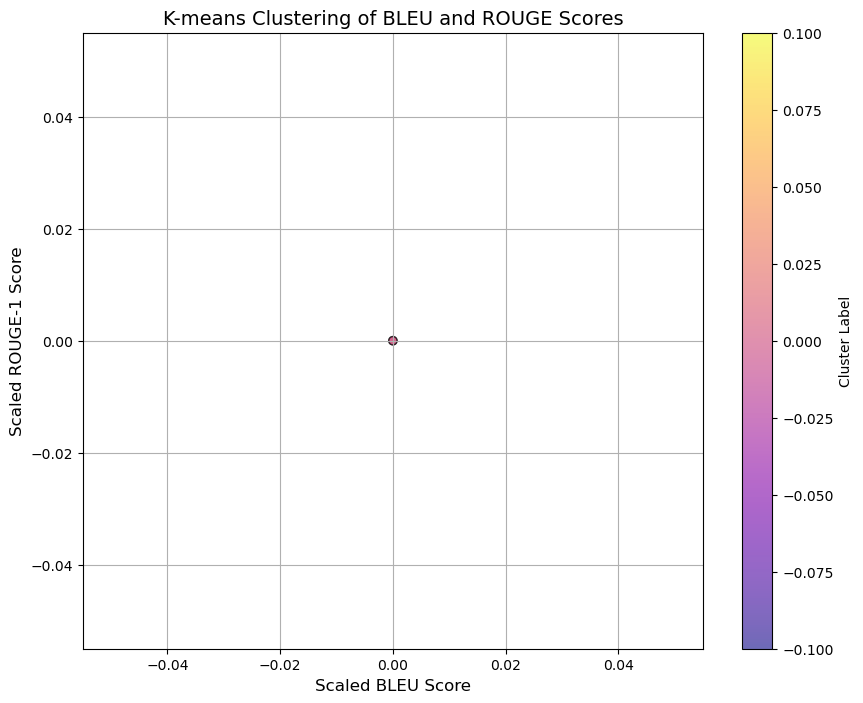

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


# create list for reference(input captions) and generated(output captions)

reference_captions = [prompt, prompt]
generated_captions = [stability_ai_caption, dalle_caption]

# Print out the captions for debugging
print("Reference Captions:", reference_captions)
print("Generated Captions:", generated_captions)

# Calculate BLEU scores
bleu_scores = [sentence_bleu([ref.split()], gen.split()) for ref, gen in zip(reference_captions, generated_captions)]

# Calculate ROUGE scores
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores = [scorer.score(ref, gen) for ref, gen in zip(reference_captions, generated_captions)]
rouge1_scores = [score['rouge1'].fmeasure for score in rouge_scores]

# Prepare data for K-means
X = np.array(list(zip(bleu_scores, rouge1_scores)))

# Apply StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-means clustering
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_scaled)
labels = kmeans.labels_

# Plotting
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='plasma', alpha=0.6, edgecolor='k')

# Annotating points
for i, txt in enumerate(generated_captions):
    plt.annotate(txt, (X_scaled[i, 0], X_scaled[i, 1]), fontsize=9, alpha=0.7)

plt.title('K-means Clustering of BLEU and ROUGE Scores', fontsize=14)
plt.xlabel('Scaled BLEU Score', fontsize=12)
plt.ylabel('Scaled ROUGE-1 Score', fontsize=12)
plt.colorbar(scatter, label='Cluster Label')
plt.grid(True)

# Show plot
plt.show()


In [163]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import ast

# Load dataframe
df = pd.read_csv('image_generation_results.csv')

# Check for 'User Preference'
if 'User Preference' not in df.columns:
    raise ValueError("User Preference column not found in the DataFrame.")

# Flatten ROUGE score tuples if needed
def flatten_rouge_scores(rouge_column):
    print(f"Flattening scores from: {rouge_column}")
    return pd.DataFrame(df[rouge_column].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x).tolist(), index=df.index)

# Extract and flatten ROUGE scores
rouge_stability = flatten_rouge_scores('Stability AI Rouge')
rouge_dalle = flatten_rouge_scores('Dall-E Rouge')

# Print shapes of the flattened scores
print(f"Stability AI Rouge shape: {rouge_stability.shape}")
print(f"Dall-E Rouge shape: {rouge_dalle.shape}")

# Ensure we have the correct number of columns
if rouge_stability.shape[1] != 3 or rouge_dalle.shape[1] != 3:
    raise ValueError("Expected 3 columns for ROUGE scores but got different numbers.")

# Add flattened scores back to DataFrame
df[['Stability AI Rouge1', 'Stability AI Rouge2', 'Stability AI RougeL']] = rouge_stability
df[['Dall-E Rouge1', 'Dall-E Rouge2', 'Dall-E RougeL']] = rouge_dalle

# Select features and target variable
features = ['Stability AI Rouge1', 'Stability AI Rouge2', 'Stability AI RougeL',
            'Dall-E Rouge1', 'Dall-E Rouge2', 'Dall-E RougeL',
            'Stability AI BLEU', 'Dall-E BLEU']

# Remove any rows with NaN values
X = df[features].dropna()
y = df.loc[X.index, 'User Preference']

# Check if X and y are empty
if X.empty or y.empty:
    print("No data available for training.")
    print(f"Shape of features: {X.shape}, Shape of target: {y.shape}")
else:
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit Random Forest model
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))


Flattening scores from: Stability AI Rouge


ValueError: malformed node or string on line 1: <ast.Call object at 0x7f9acc455de0>

Output results to file

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load dataframe
df = pd.read_csv('image_generation_results.csv')

# Check for 'User Preference'
if 'User Preference' not in df.columns:
    raise ValueError("User Preference column not found in the DataFrame.")

# Flatten ROUGE score tuples if needed
def flatten_rouge_scores(rouge_column):
    # Check the contents of the column before processing
    print(f"Flattening scores from: {rouge_column}")
    return pd.DataFrame(df[rouge_column].apply(lambda x: eval(x) if isinstance(x, str) else x).tolist(), index=df.index)

# Extract and flatten ROUGE scores
rouge_stability = flatten_rouge_scores('Stability AI Rouge')
rouge_dalle = flatten_rouge_scores('Dall-E Rouge')

# Print shapes of the flattened scores
print(f"Stability AI Rouge shape: {rouge_stability.shape}")
print(f"Dall-E Rouge shape: {rouge_dalle.shape}")

# Ensure we have the correct number of columns
if rouge_stability.shape[1] != 3 or rouge_dalle.shape[1] != 3:
    raise ValueError("Expected 3 columns for ROUGE scores but got different numbers.")

# Add flattened scores back to DataFrame
df[['Stability AI Rouge1', 'Stability AI Rouge2', 'Stability AI RougeL']] = rouge_stability
df[['Dall-E Rouge1', 'Dall-E Rouge2', 'Dall-E RougeL']] = rouge_dalle

# Select features and target variable
features = ['Stability AI Rouge1', 'Stability AI Rouge2', 'Stability AI RougeL',
            'Dall-E Rouge1', 'Dall-E Rouge2', 'Dall-E RougeL',
            'Stability AI BLEU', 'Dall-E BLEU']

# Remove any rows with NaN values
X = df[features].dropna()
y = df.loc[X.index, 'User Preference']

# Check if X and y are empty
if X.empty or y.empty:
    print("No data available for training.")
    print(f"Shape of features: {X.shape}, Shape of target: {y.shape}")
else:
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit Random Forest model
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))


Flattening scores from: Stability AI Rouge


NameError: name 'Score' is not defined